In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.linear_model import LinearRegression
from skimage.transform import rotate,warp
import os
localdir = "/mnt/c/Users/rober/OneDrive/Desktop/linux_stuff/mlearning/image_processing/"
#localdir = !pwd

In [2]:
def show_bgr(frame,w=20):
    plt.figure(figsize=(w,int(w/1.6)))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()

/mnt/c/Users/rober/OneDrive/Desktop/linux_stuff/mlearning/image_processing
3
50


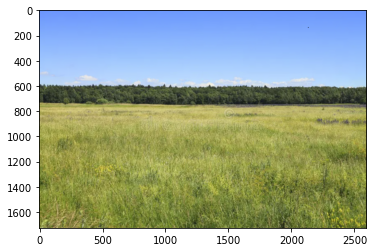

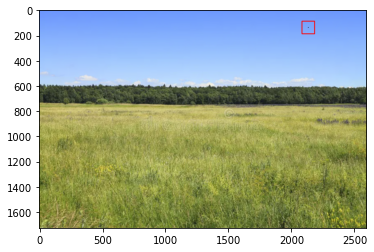

True

In [3]:

def add_dot_and_bounding_box(image, xmin, xmax, ymin, ymax, object_size):
    """
    Adds a dark orange dot to the image by directly overwriting the relevant pixels
    and creates a second image with the dot highlighted by a large bright red bounding box.

    Parameters:
        image (numpy.ndarray): The input image.
        xmin (int): The minimum x-coordinate of the bounding box.
        xmax (int): The maximum x-coordinate of the bounding box.
        ymin (int): The minimum y-coordinate of the bounding box.
        ymax (int): The maximum y-coordinate of the bounding box.
        object_size (int): The size (radius) of the dot in pixels.

    Returns:
        tuple: A tuple containing two images:
            - image_with_dot (numpy.ndarray): Image with the dark orange dot.
            - image_with_dot_and_box (numpy.ndarray): Image with the dot and red bounding box.
    """
    # Create copies of the original image for both outputs
    image_with_dot = image.copy()

    # Calculate the center of the bounding box

    # Ensure the bounding box is large enough to contain the dot
    if (xmax - xmin) < 2 * object_size or (ymax - ymin) < 2 * object_size:
        raise ValueError("Bounding box is too small to contain the dot with the specified object_size.")

    # Generate a random center within the bounding box, ensuring the dot stays within bounds
    center_x = np.random.randint(xmin + object_size, xmax - object_size)
    center_y = np.random.randint(ymin + object_size, ymax - object_size)
    center = (center_x, center_y)


    # Define the color for the dot (Dark Orange in BGR)
    dot_color = (0, 1, 1)  # BGR format

    # Create a mask for the dot
    mask = np.zeros_like(image_with_dot, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, center, object_size, dot_color, -1)

    # Overwrite the relevant pixels with the dot color
    # If the image has multiple channels
    if len(image_with_dot.shape) == 3 and image_with_dot.shape[2] == 3:
        # Create a boolean mask where the circle is drawn
        circle_mask = mask.any(axis=2)
        # Overwrite the pixels in the original image
        image_with_dot[circle_mask] = mask[circle_mask]
    else:
        # For grayscale images
        image_with_dot = np.where(mask > 0, mask, image_with_dot)

    # For the second image, add a bright red bounding box around the dot
    # Define the color for the bounding box (Bright Red in BGR)
    box_color = (0, 0, 255)  # BGR format
   

    # Calculate the top-left and bottom-right points of the bounding box
    print(object_size)
    box_size = np.max([50,object_size * 2])
    print(box_size)
    box_thickness = max(5, object_size // 5)  # Adjust thickness based on object size
    top_left = (center_x - box_size, center_y - box_size)
    bottom_right = (center_x + box_size, center_y + box_size)

    # Ensure the bounding box is within image boundaries
    top_left = (max(top_left[0], 0), max(top_left[1], 0))
    bottom_right = (min(bottom_right[0], image.shape[1] - 1), min(bottom_right[1], image.shape[0] - 1))

    image_with_box = image_with_dot.copy()
        
    # Draw the bounding box on the second image
    cv2.rectangle(image_with_box, top_left, bottom_right, box_color, box_thickness)

    return image_with_dot, image_with_box

#print current directory
print(os.getcwd())
img = cv2.imread("/mnt/c/Users/rober/OneDrive/Desktop/linux_stuff/mlearning/image_processing/images/base_images/horizon_2.png")

img_dot, img_box = add_dot_and_bounding_box(img, xmin=50, xmax=2450, ymin=0, ymax=200, object_size=3)
imd = cv2.cvtColor(img_dot, cv2.COLOR_BGR2RGB)
plt.imshow(imd)
plt.show()
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('image_with_dot.jpg', img_dot)
cv2.imwrite('image_with_box.jpg', img_box)


In [4]:
import cv2
import numpy as np

def add_dot_and_bounding_box_precisely_with_smear(image, x_center, y_center, object_size):
    # Create copies of the original image for both outputs
    image_with_dot = image.copy()

    # Get image dimensions
    height, width = image.shape[:2]

    # Validate that the dot will be fully within the image boundaries
    if not (object_size <= x_center < width - object_size and
            object_size <= y_center < height - object_size):
        raise ValueError("The dot with the specified object_size does not fit within the image boundaries at the given center coordinates.")

    center = (x_center, y_center)

    # Define the color for the dot (Dark Orange in BGR)
    dot_color = (94, 114, 117)  # BGR format
    
    # Create a Gaussian mask for the dot's fading effect
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Generate a Gaussian distribution centered at (x_center, y_center)
    sigma = object_size / 2.0  # Set the standard deviation based on object size
    gaussian_mask = np.exp(-0.5 * (distance_from_center / sigma) ** 2)
    
    # Normalize the mask to have values between 0 and 1
    gaussian_mask = np.clip(gaussian_mask, 0, 1)

    # Now, we use the Gaussian mask to apply the color with fading effect
    for c in range(3):  # Apply the effect for each channel (BGR)
        image_with_dot[..., c] = np.clip(image_with_dot[..., c] * (1 - gaussian_mask) + dot_color[c] * gaussian_mask, 0, 255)

    # Define the color for the bounding box (Bright Red in BGR)
    box_color = (0, 0, 255)  # BGR format
    box_thickness = max(2, object_size // 5)  # Adjust thickness based on object size

    # Calculate the top-left and bottom-right points of the bounding box
    box_size = object_size * 2
    top_left = (x_center - box_size, y_center - box_size)
    bottom_right = (x_center + box_size, y_center + box_size)

    # Ensure the bounding box is within image boundaries
    top_left = (max(top_left[0], 0), max(top_left[1], 0))
    bottom_right = (min(bottom_right[0], width - 1), min(bottom_right[1], height - 1))

    image_with_box = image_with_dot.copy()

    # Draw the bounding box on the second image
    cv2.rectangle(image_with_box, top_left, bottom_right, box_color, box_thickness)

    return image_with_dot, image_with_box


In [5]:
def add_dot_and_bounding_box_precisely(image, x_center, y_center, object_size):
    # Create copies of the original image for both outputs
    image_with_dot = image.copy()

    # Get image dimensions
    height, width = image.shape[:2]

    # Validate that the dot will be fully within the image boundaries
    if not (object_size <= x_center < width - object_size and
            object_size <= y_center < height - object_size):
        raise ValueError("The dot with the specified object_size does not fit within the image boundaries at the given center coordinates.")

    center = (x_center, y_center)

    # Define the color for the dot (Dark Orange in BGR)
    #dot_color = (44,53,56)  # BGR format
    dot_color = (94,114,117)  # BGR format

    # Draw the filled circle (dot) directly on the image
    cv2.circle(image_with_dot, center, object_size, dot_color, -1)

    # Define the color for the bounding box (Bright Red in BGR)
    box_color = (0, 0, 255)  # BGR format
    box_thickness = max(2, object_size // 5)  # Adjust thickness based on object size

    # Calculate the top-left and bottom-right points of the bounding box
    box_size = object_size * 2
    top_left = (x_center - box_size, y_center - box_size)
    bottom_right = (x_center + box_size, y_center + box_size)

    # Ensure the bounding box is within image boundaries
    top_left = (max(top_left[0], 0), max(top_left[1], 0))
    bottom_right = (min(bottom_right[0], width - 1), min(bottom_right[1], height - 1))

    image_with_box = image_with_dot.copy()
    
    # Draw the bounding box on the second image
    cv2.rectangle(image_with_box, top_left, bottom_right, box_color, box_thickness)

    return image_with_dot, image_with_box

In [6]:
def generate_frames(base_image,inter_frame_speed=10,object_size=2):
    """
    Generates 60 images with a moving dot and corresponding bounding boxes.
    The dot moves horizontally from x=100 to x=100 + 10*59=690 at y=300.
    Saves the images in the 'syth_track/' directory with sequential naming.
    """
    # Define output directory
    output_dir = 'synth_track'
    output_dir_box = 'synth_track_box'
    
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_dir_box, exist_ok=True)
    
    
    # Define dot properties
    y_center = 300
    initial_x = 100
    inter_frame_speed = 10 #jump 10 x pixels between every frame
    total_frames = 60
    object_size = 2

    for i in range(total_frames):
        frame_number = i + 1
        x_center = initial_x + inter_frame_speed * i

        # Add dot and bounding box to the base image
        img_dot, img_box = add_dot_and_bounding_box_precisely(base_image, x_center, y_center, object_size)

        filename_dot = os.path.join(output_dir, f'frame_{frame_number:03}.jpg')
        filename_box = os.path.join(output_dir_box, f'frame_{frame_number:03}_box.jpg')

        # Save the images
        cv2.imwrite(filename_dot, img_dot)
        cv2.imwrite(filename_box, img_box)


In [7]:
import cv2
import os
import glob

def assemble_frames_to_video(input_dir, output_video_path, fps=15, frame_pattern='frame_*.jpg'):
    """
    Assembles all image frames in the specified directory into a video.

    Parameters:
        input_dir (str): Path to the directory containing the image frames.
        output_video_path (str): Path where the output video will be saved (e.g., 'output_video.mp4').
        fps (int, optional): Frames per second for the output video. Default is 15.
        frame_pattern (str, optional): Glob pattern to match frame filenames. Default is 'frame_*.jpg'.

    Raises:
        ValueError: If no frames are found in the specified directory.
    """
    # Get list of frame file paths matching the pattern
    frame_files = sorted(glob.glob(os.path.join(input_dir, frame_pattern)))

    if not frame_files:
        raise ValueError(f"No frames found in directory '{input_dir}' with pattern '{frame_pattern}'.")

    # Read the first frame to get frame dimensions
    first_frame = cv2.imread(frame_files[0])
    if first_frame is None:
        raise ValueError(f"Unable to read the first frame: {frame_files[0]}")

    height, width, channels = first_frame.shape

    # Define the codec and create VideoWriter object
    # For MP4 output, use 'mp4v' codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    print(f"Starting video assembly from {len(frame_files)} frames...")

    for idx, frame_file in enumerate(frame_files):
        frame = cv2.imread(frame_file)
        if frame is None:
            print(f"Warning: Skipping unreadable frame: {frame_file}")
            continue

        # Check if frame size matches the first frame
        if frame.shape != first_frame.shape:
            print(f"Warning: Skipping frame with mismatched size: {frame_file}")
            continue

        video_writer.write(frame)

        if (idx + 1) % 10 == 0 or (idx + 1) == len(frame_files):
            print(f"Processed {idx + 1}/{len(frame_files)} frames.")

    # Release the VideoWriter
    video_writer.release()
    print(f"Video successfully saved to '{output_video_path}'.")



In [8]:
#img = cv2.imread("images/base_images/horizon_3.jpg")
img = cv2.imread(localdir+"/images/base_images/horizon_2.png")

generate_frames(img)


In [9]:
input_directory = 'synth_track_box'  # Directory containing the frames
output_video = 'synth_track_video_box.mp4'  # Desired output video file name
frames_per_second = 15  # FPS for the video
frame_glob_pattern = 'frame*.jpg'  # Pattern to match frames with bounding boxes

try:
    assemble_frames_to_video(
        input_dir=input_directory,
        output_video_path=output_video,
        fps=frames_per_second,
        frame_pattern=frame_glob_pattern
    )
except ValueError as ve:
    print(f"Error: {ve}")

input_directory = 'synth_track'  # Directory containing the frames
output_video = 'synth_track_video.mp4'  # Desired output video file name
frames_per_second = 15  # FPS for the video
frame_glob_pattern = 'frame*.jpg'  # Pattern to match frames with bounding boxes

try:
    assemble_frames_to_video(
        input_dir=input_directory,
        output_video_path=output_video,
        fps=frames_per_second,
        frame_pattern=frame_glob_pattern
    )
except ValueError as ve:
    print(f"Error: {ve}")

input_directory = 'synth_track_pose'  # Directory containing the frames
output_video = 'synth_track_pose_video.mp4'  # Desired output video file name
frames_per_second = 15  # FPS for the video
frame_glob_pattern = 'frame*.jpg'  # Pattern to match frames with bounding boxes

try:
    assemble_frames_to_video(
        input_dir=input_directory,
        output_video_path=output_video,
        fps=frames_per_second,
        frame_pattern=frame_glob_pattern
    )
except ValueError as ve:
    print(f"Error: {ve}")

Starting video assembly from 60 frames...
Processed 10/60 frames.
Processed 20/60 frames.
Processed 30/60 frames.
Processed 40/60 frames.
Processed 50/60 frames.
Processed 60/60 frames.
Video successfully saved to 'synth_track_video_box.mp4'.
Starting video assembly from 60 frames...
Processed 10/60 frames.
Processed 20/60 frames.
Processed 30/60 frames.
Processed 40/60 frames.
Processed 50/60 frames.
Processed 60/60 frames.
Video successfully saved to 'synth_track_video.mp4'.
Starting video assembly from 60 frames...
Processed 10/60 frames.
Processed 20/60 frames.
Processed 30/60 frames.
Processed 40/60 frames.
Processed 50/60 frames.
Processed 60/60 frames.
Video successfully saved to 'synth_track_pose_video.mp4'.


2
50


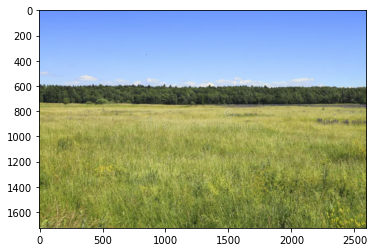

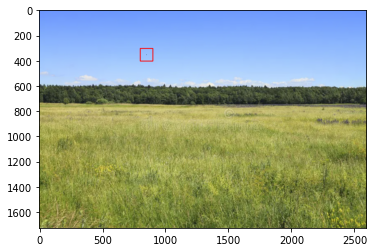

True

In [10]:
# Example usage:

img_dot, img_box = add_dot_and_bounding_box(img, xmin=50, xmax=1150, ymin=50, ymax=500, object_size=2)
imd = cv2.cvtColor(img_dot, cv2.COLOR_BGR2RGB)
plt.imshow(imd)
plt.show()
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('image_with_dot.jpg', img_dot)
cv2.imwrite('image_with_box.jpg', img_box)

In [11]:
def annotate_truth(frame,yaw_deg,pitch_deg, zoom_val, cx,
                                    cy,
                                    object_size):
    # Prepare the text to be displayed
    text = f"Object: ({int(cx)}, {int(cy)}), {int(object_size)} pixels wide | Camera: {int(yaw_deg)} Yaw, {int(pitch_deg)} Pitch, {zoom_val:.1f} Zoom"

    # Set the font, scale, color, and thickness for the text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    color = (0, 255, 255)  # Bright yellow color (BGR)
    thickness = 5
    
    # Get the text size to position it correctly at the bottom
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_width, text_height = text_size
    
    # Calculate the position for the text at the bottom of the image
    x_pos = (frame.shape[1] - text_width) // 2  # Centered horizontally
    y_pos = frame.shape[0] - 10  # Just above the bottom border
    
    # Add the text to the image
    cv2.putText(frame, text, (x_pos, y_pos), font, font_scale, color, thickness)
    
    return frame


In [12]:
import cv2
import numpy as np
import random
import os

def simulate_camera_capture(
    large_image_path,
    output_folder,
    num_images=5,
    output_width=1920,
    output_height=1080,
    max_corner_perturb=50,
    seed=None
):
    """
    Simulate a 1920x1080 camera capturing views from a larger scene image.
    Saves the generated synthetic images to the specified output_folder.

    Parameters:
    -----------
    large_image_path : str
        Path to the large input image (must be bigger than 1920x1080).
    output_folder : str
        Folder where the resulting images will be saved.
    num_images : int
        Number of random captures to generate.
    output_width : int
        Output "camera" width (default 1920).
    output_height : int
        Output "camera" height (default 1080).
    max_corner_perturb : int
        Maximum random displacement applied to each corner (in pixels).
    seed : int or None
        If set, ensures reproducible random results.
    """

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Read the large input image
    large_image = cv2.imread(large_image_path)
    if large_image is None:
        raise ValueError(f"Could not read image at {large_image_path}")

    H, W, _ = large_image.shape
    if W < output_width or H < output_height:
        raise ValueError("Input image must be larger than the requested 1920x1080 output size.")

    # Prepare the destination corner points for a 1920x1080 rectangle
    dst_pts = np.array([
        [0,             0],
        [output_width-1, 0],
        [output_width-1, output_height-1],
        [0,             output_height-1]
    ], dtype=np.float32)

    # Make sure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i in range(num_images):
        # Randomly choose a base top-left corner within safe bounds
        # so we have enough space for a 1920x1080 region plus some random perturbation
        x1 = random.randint(0, W - output_width)
        y1 = random.randint(0, H - output_height)

        # Helper function to clamp a value into [0, max_val]
        def clamp(val, minimum, maximum):
            return max(minimum, min(val, maximum))

        # Define corners in the source image with random perturbations
        # We first define them as the perfect rectangle, then add random offsets
        tl = (
            clamp(x1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, W-1),
            clamp(y1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, H-1)
        )
        tr = (
            clamp(x1 + output_width - 1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, W-1),
            clamp(y1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, H-1)
        )
        br = (
            clamp(x1 + output_width - 1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, W-1),
            clamp(y1 + output_height - 1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, H-1)
        )
        bl = (
            clamp(x1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, W-1),
            clamp(y1 + output_height - 1 + random.randint(-max_corner_perturb, max_corner_perturb), 0, H-1)
        )

        src_pts = np.array([tl, tr, br, bl], dtype=np.float32)

        # Compute the perspective transform that maps src_pts -> dst_pts
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Warp the large image to the new 1920x1080 viewpoint
        synthetic_view = cv2.warpPerspective(large_image, M, (output_width, output_height))

        # Construct an output filename and save
        out_path = os.path.join(output_folder, f"synthetic_{i:03d}.jpg")
        cv2.imwrite(out_path, synthetic_view)

        print(f"Saved {out_path}")



simulate_camera_capture(
#large_image_path="images/base_images/horizon_2.png",
large_image_path="images/base_images/horizon_2.png",
    
output_folder="output_synthetic",
num_images=20,           # generate 10 synthetic camera shots
output_width=1920,
output_height=1080,
max_corner_perturb=100,  # increase this for more dramatic perspective
seed=42                  # for reproducibility, remove or set None for random
)


Saved output_synthetic/synthetic_000.jpg
Saved output_synthetic/synthetic_001.jpg
Saved output_synthetic/synthetic_002.jpg
Saved output_synthetic/synthetic_003.jpg
Saved output_synthetic/synthetic_004.jpg
Saved output_synthetic/synthetic_005.jpg
Saved output_synthetic/synthetic_006.jpg
Saved output_synthetic/synthetic_007.jpg
Saved output_synthetic/synthetic_008.jpg
Saved output_synthetic/synthetic_009.jpg
Saved output_synthetic/synthetic_010.jpg
Saved output_synthetic/synthetic_011.jpg
Saved output_synthetic/synthetic_012.jpg
Saved output_synthetic/synthetic_013.jpg
Saved output_synthetic/synthetic_014.jpg
Saved output_synthetic/synthetic_015.jpg
Saved output_synthetic/synthetic_016.jpg
Saved output_synthetic/synthetic_017.jpg
Saved output_synthetic/synthetic_018.jpg
Saved output_synthetic/synthetic_019.jpg


In [13]:
import cv2
import numpy as np
import os
import math

def generate_sequence(
    large_image_path,
    output_folder,
    num_frames=60,
    output_width=1920,
    output_height=1080,
    # Zoom range from 1.0 (no zoom) up to 2.0 (2x zoom) across the sequence
    zoom_start=1.0,
    zoom_end=2.0,
    # Pitch range: start at 0° (no “look up”), end at -15° (look up)
    pitch_start_deg=0.0,
    pitch_end_deg=-15.0,
    # Yaw range: oscillate between -45° and +45°
    yaw_amplitude_deg=45.0,
    yaw_period=20,  # frames per full oscillation (2π)
    seed=None
):
    """
    Generate a synthetic sequence of 1920x1080 images from a larger image.
    The camera "pitches" upward more and more (never looking downward),
    "zooms in" over time, and "yaws" (rotates left/right) gently in-plane.

    Parameters
    ----------
    large_image_path : str
        Path to a large input image (must be bigger than 1920x1080).
    output_folder : str
        Folder where frames will be saved.
    num_frames : int
        Number of frames in the sequence.
    output_width : int
        Width of the synthetic camera output.
    output_height : int
        Height of the synthetic camera output.
    zoom_start : float
        Initial zoom factor at the first frame.
    zoom_end : float
        Final zoom factor at the last frame.
    pitch_start_deg : float
        Initial pitch (in degrees). Positive means looking down, negative means up.
    pitch_end_deg : float
        Final pitch (in degrees).
    yaw_amplitude_deg : float
        Maximum in-plane rotation (in degrees) to each side.
    yaw_period : int
        Number of frames per full left-right-left oscillation.
    seed : int or None
        If not None, seed the random number generator for reproducibility.
    """
    if seed is not None:
        np.random.seed(seed)

    # Read the large input image
    large_img = cv2.imread(large_image_path)
    if large_img is None:
        raise ValueError(f"Could not load '{large_image_path}'.")
    H, W, _ = large_img.shape

    if W < output_width or H < output_height:
        raise ValueError("Input image must be larger than the requested 1920x1080 output size.")

    # Make sure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # We’ll define a helper to get the 4 corners in the large image
    # based on the current zoom, pitch, and yaw. Then we’ll map them
    # to the 1920x1080 corners.
    #
    # The base “camera rectangle” in local coordinates (centered at 0,0):
    #   top-left:     (-w/2, -h/2)
    #   top-right:    ( w/2, -h/2)
    #   bottom-right: ( w/2,  h/2)
    #   bottom-left:  (-w/2,  h/2)
    #
    # We'll apply (zoom, yaw, pitch) transforms in that local space,
    # then shift to the center of the large image.
    #
    # "Pitch" we simulate by “pushing” or “pulling” the top edge in Y
    # to mimic an upward tilt. Negative pitch means top corners are “further up.”

    # Destination corners for the 1920x1080 output
    dst_corners = np.float32([
        [0,             0],
        [output_width-1, 0],
        [output_width-1, output_height-1],
        [0,             output_height-1]
    ])

    # We'll treat the center of the large image as the "look at" point
    cx, cy = W / 2.0, H / 2.0

    half_w_out = output_width / 2.0
    half_h_out = output_height / 2.0

    for i in range(num_frames):
        # Progress fraction from 0 to 1
        t = i / float(num_frames - 1) if num_frames > 1 else 0

        # Current zoom
        zoom = zoom_start + t * (zoom_end - zoom_start)

        # Current pitch in degrees
        pitch_deg = pitch_start_deg + t * (pitch_end_deg - pitch_start_deg)
        pitch_rad = np.deg2rad(pitch_deg)

        # Current yaw in degrees, oscillating
        # One full cycle every 'yaw_period' frames => use sine
        yaw_deg = yaw_amplitude_deg * math.sin(2.0 * math.pi * i / yaw_period)
        yaw_rad = np.deg2rad(yaw_deg)

        # Define corners in local space (centered at 0,0)
        # base corners are half_w_out by half_h_out
        local_corners = np.float32([
            [-half_w_out, -half_h_out],
            [ half_w_out, -half_h_out],
            [ half_w_out,  half_h_out],
            [-half_w_out,  half_h_out],
        ])

        # Apply zoom
        local_corners *= zoom

        # Apply in-plane yaw rotation around (0,0)
        #  [x']   [ cos(yaw) -sin(yaw) ] [x]
        #  [y'] = [ sin(yaw)  cos(yaw) ] [y]
        cos_yaw = math.cos(yaw_rad)
        sin_yaw = math.sin(yaw_rad)
        R = np.array([
            [cos_yaw, -sin_yaw],
            [sin_yaw,  cos_yaw]
        ], dtype=np.float32)
        local_corners = local_corners @ R.T  # shape (4,2)

        # Apply pitch:
        # For a negative pitch (looking up), we want the top corners
        # to shift upward or become "closer together" to create a
        # perspective effect. We'll approximate a perspective offset by
        # adjusting the y-coordinates of the top corners more strongly than
        # the bottom corners. The bigger the pitch magnitude, the stronger
        # the difference.
        #
        # A simple hacky approach: we shift the top corners' y
        # by some fraction of pitch. The bigger the negative pitch, the more
        # we raise the top corners. We'll also shift the bottom corners slightly
        # the other way if we want a bigger effect. This is not a full 3D model,
        # but is a workable 2D approximation.
        #
        # local_corners: [tl, tr, br, bl]
        #   top corners => index 0,1  (y negative if no pitch transform)
        #   bottom corners => index 2,3

        # The magnitude factor for pitch we can tweak:
        pitch_factor = 0.002  # bigger => stronger perspective
        # We'll move the top corners up by (pitch_rad * pitch_factor * y-range)
        # and the bottom corners down by a smaller fraction if needed.
        y_range = half_h_out * zoom
        offset = pitch_rad * pitch_factor * y_range

        # top corners (0,1) => shift upward by offset
        local_corners[0, 1] += offset
        local_corners[1, 1] += offset
        # (Optional) push bottom corners (2,3) in the opposite direction by offset/2
        local_corners[2, 1] -= offset * 0.5
        local_corners[3, 1] -= offset * 0.5

        # Now local_corners is our region in some 2D coordinate system
        # around (0,0). We shift to (cx, cy) in the large image.
        src_corners = local_corners + np.float32([cx, cy])

        # Make sure the corners are within the image. If they go out of bounds,
        # warpPerspective will produce black areas. Here we just clamp them,
        # or you can keep them out of bounds if you want black edges.
        src_corners[:, 0] = np.clip(src_corners[:, 0], 0, W-1)
        src_corners[:, 1] = np.clip(src_corners[:, 1], 0, H-1)

        # Compute perspective transform
        M = cv2.getPerspectiveTransform(src_corners, dst_corners)

        # Warp to 1920x1080
        frame = cv2.warpPerspective(large_img, M, (output_width, output_height))

        # Save
        out_name = f"frame_{i:03d}.jpg"
        out_path = os.path.join(output_folder, out_name)
        cv2.imwrite(out_path, frame)
        print(f"Saved {out_path}")

# Example usage:
generate_sequence(
    #large_image_path="path/to/your/large_image.jpg",
    large_image_path = "images/base_images/horizon_2.png",
    output_folder="output_sequence",
    num_frames=60,
    # 1920x1080 camera
    output_width=1920,
    output_height=1080,
    # Zoom from 1.0 to 2.0
    zoom_start=1.0,
    zoom_end=2.0,
    # Pitch from 0° (flat) to -15° (looking up)
    pitch_start_deg=0,
    pitch_end_deg=-15,
    # Yaw oscillation ±45°
    yaw_amplitude_deg=45,
    yaw_period=20,  # how many frames it takes to go -45->+45->-45
    seed=42  # for reproducibility (optional)
)


Saved output_sequence/frame_000.jpg
Saved output_sequence/frame_001.jpg
Saved output_sequence/frame_002.jpg
Saved output_sequence/frame_003.jpg
Saved output_sequence/frame_004.jpg
Saved output_sequence/frame_005.jpg
Saved output_sequence/frame_006.jpg
Saved output_sequence/frame_007.jpg
Saved output_sequence/frame_008.jpg
Saved output_sequence/frame_009.jpg
Saved output_sequence/frame_010.jpg
Saved output_sequence/frame_011.jpg
Saved output_sequence/frame_012.jpg
Saved output_sequence/frame_013.jpg
Saved output_sequence/frame_014.jpg
Saved output_sequence/frame_015.jpg
Saved output_sequence/frame_016.jpg
Saved output_sequence/frame_017.jpg
Saved output_sequence/frame_018.jpg
Saved output_sequence/frame_019.jpg
Saved output_sequence/frame_020.jpg
Saved output_sequence/frame_021.jpg
Saved output_sequence/frame_022.jpg
Saved output_sequence/frame_023.jpg
Saved output_sequence/frame_024.jpg
Saved output_sequence/frame_025.jpg
Saved output_sequence/frame_026.jpg
Saved output_sequence/frame_

In [17]:
import cv2
import numpy as np
import os
import math

def generate_sequence_with_moving_dot(
    large_image_path='images/base_images/horizon_12.png',
    output_dir_dot="synth_track",
    output_dir_box="synth_track_box",
    output_dir_pose="synth_track_pose",
    num_frames=60,
    output_width=1920,
    output_height=1080,
    # Zoom range from 1.0 (no zoom) up to 2.0 (2x zoom)
    zoom_start=1,
    zoom_end=0.3,
    # Pitch range: start at 0° (flat), end at -15° (looking up)
    pitch_start_deg=0.0,
    pitch_end_deg=-45.0,
    # Yaw range: oscillate between -45° and +45°
    yaw_amplitude_deg=30.0,
    yaw_period=60,  # frames per full left-right-left cycle
    # Dot motion parameters
    dot_y_center=300,
    dot_initial_x=800,
    dot_inter_frame_speed=10,   # jump 10 px in x each frame
    dot_size=2,
    seed=42
):
    """
    Generate 60 frames of a 1920x1080 "camera" viewing a larger image, with:
      - Zoom in from 1.0 to 2.0
      - Pitch upward from 0 to -15 deg
      - Yaw oscillation from -45 to +45 deg
    Also place a moving dot (and bounding box) in the large image before warping,
    so the dot warps in the final output.

    Outputs three sets of images:
      1) <output_dir_dot> : images with the dot only, warped to 1920x1080
      2) <output_dir_box> : images with the dot + bounding box, warped to 1920x1080
      3) <output_dir_pose>: large/base image with dot + bounding box + a drawn rectangle
                            showing the camera's FOV (i.e. src_corners).
    """
    if seed is not None:
        np.random.seed(seed)

    # Read the large input image
    large_img_original = cv2.imread(large_image_path)
    if large_img_original is None:
        raise ValueError(f"Could not load '{large_image_path}'.")
    large_img_original = large_img_original[0:1400,0:large_img_original.shape[1]]
    H, W, _ = large_img_original.shape

    if W < output_width or H < output_height:
        raise ValueError("Input image must be larger than the requested output size.")

    # Make sure the output directories exist
    os.makedirs(output_dir_dot, exist_ok=True)
    os.makedirs(output_dir_box, exist_ok=True)
    os.makedirs(output_dir_pose, exist_ok=True)

    # Destination corners for the 1920x1080 output
    dst_corners = np.float32([
        [0,             0],
        [output_width-1, 0],
        [output_width-1, output_height-1],
        [0,             output_height-1]
    ])

    # We'll treat the center of the large image as the "look at" point
    cx, cy = W / 2.0, H / 2.0

    # Half-width/half-height of the camera in "local" coords
    half_w_out = output_width / 2.0
    half_h_out = output_height / 2.0

    for i in range(num_frames):
        cy -=5
        frame_number = i + 1

        # Compute fraction t from 0..1 across frames
        t = i / float(num_frames - 1) if num_frames > 1 else 0

        # Current zoom
        zoom = zoom_start + t * (zoom_end - zoom_start)

        # Current pitch in degrees (negative => looking up)
        pitch_deg = pitch_start_deg + t * (pitch_end_deg - pitch_start_deg)
        pitch_rad = math.radians(pitch_deg)

        # Current yaw in degrees: oscillate +/- yaw_amplitude_deg
        yaw_deg = yaw_amplitude_deg * math.sin(2.0 * math.pi * i / yaw_period)
        yaw_rad = math.radians(yaw_deg)

        # ---- STEP 1: Place the moving dot in the large image before warping ----
        dot_x_center = dot_initial_x + dot_inter_frame_speed * i

        # Make a copy of the large image so we don't overwrite original
        large_img = large_img_original.copy()

        # Draw the dot and bounding box
        img_dot, img_box = add_dot_and_bounding_box_precisely_with_smear(
            large_img,
            dot_x_center,
            dot_y_center,
            object_size=dot_size
        )

        # ---- STEP 2: Compute the source corners in "local" coords, then transform. ----
        # Base corners of the camera in local coords, centered at (0,0)
        local_corners = np.float32([
            [-half_w_out, -half_h_out],
            [ half_w_out, -half_h_out],
            [ half_w_out,  half_h_out],
            [-half_w_out,  half_h_out],
        ])

        # Apply zoom
        local_corners *= zoom

        # Apply in-plane yaw rotation
        cos_yaw = math.cos(yaw_rad)
        sin_yaw = math.sin(yaw_rad)
        R = np.array([
            [cos_yaw, -sin_yaw],
            [sin_yaw,  cos_yaw]
        ], dtype=np.float32)
        local_corners = local_corners @ R.T  # rotate around (0,0)

        # Approximate pitch by shifting top/bottom edges differently
        pitch_factor = 0.002
        y_range = half_h_out * zoom
        offset = pitch_rad * pitch_factor * y_range
        # Move top corners up by offset
        local_corners[0, 1] += offset
        local_corners[1, 1] += offset
        # Move bottom corners slightly the other way
        local_corners[2, 1] -= offset * 0.5
        local_corners[3, 1] -= offset * 0.5

        # Translate to the center of the large image
        src_corners = local_corners + np.float32([cx, cy])

        # Optional: clamp corners so they don't go out of bounds
        src_corners[:, 0] = np.clip(src_corners[:, 0], 0, W-1)
        src_corners[:, 1] = np.clip(src_corners[:, 1], 0, H-1)

        # ---- STEP 3: Warp the images (dot vs. box) ----
        M_dot = cv2.getPerspectiveTransform(src_corners, dst_corners)
        warped_dot = cv2.warpPerspective(img_dot, M_dot, (output_width, output_height))

        M_box = cv2.getPerspectiveTransform(src_corners, dst_corners)
        warped_box = cv2.warpPerspective(img_box, M_box, (output_width, output_height))

        # ---- STEP 4: Create a "pose" image showing camera FOV on the large image. ----
        # We'll overlay the rectangle representing the corners in 'src_corners'.
        # Let’s do that on top of the "img_box" version (the large image with dot+box),
        # or you can just as easily do it on top of 'img_dot' or the original large_img.
        img_pose = img_box.copy()  # full-size large image with dot and bounding box

        # Convert corners to integer coordinates
        corners_int = [(int(x), int(y)) for x, y in src_corners]

        # Draw lines between consecutive corners: (0->1->2->3->0)
        color_fov = (255, 0, 0)  # BGR (blue) or choose your favorite color
        thickness = 2
        for c_idx in range(4):
            c1 = corners_int[c_idx]
            c2 = corners_int[(c_idx + 1) % 4]
            cv2.line(img_pose, c1, c2, color_fov, thickness)

         # === STEP 5: Annotate the final warped_box image with the dot location in camera coords ===
        # We know (dot_x_center, dot_y_center) in the large image. 
        # Let's see where it lands after perspective transform M_box.
        src_dot_center = np.array([[[dot_x_center, dot_y_center]]], dtype=np.float32)
        dst_dot_center = cv2.perspectiveTransform(src_dot_center, M_box)
        dot_x_warped, dot_y_warped = dst_dot_center[0, 0]  # (x, y)

        # Draw a small circle in the warped image to show the dot center
        #cv2.circle(warped_box, (int(dot_x_warped), int(dot_y_warped)), 5, (0,255,0), -1)
        # Put text for debugging
        cv2.putText(
            warped_box,
            f"Dot=({dot_x_warped:.1f}, {dot_y_warped:.1f})",
            (int(dot_x_warped) + 10, int(dot_y_warped)),
            cv2.FONT_HERSHEY_SIMPLEX,
            2,
            (0,255,0),
            2
        )
        
        # ---- STEP 5: Save all three versions ----
        filename_dot = os.path.join(output_dir_dot, f"frame_{frame_number:03}.jpg")
        filename_box = os.path.join(output_dir_box, f"frame_{frame_number:03}_box.jpg")
        filename_pose = os.path.join(output_dir_pose, f"frame_{frame_number:03}_pose.jpg")

        img_pose = annotate_truth(img_pose,yaw_deg,pitch_deg, zoom, dot_x_center,
                                    dot_y_center,
                                    dot_size)
                                  
        cv2.imwrite(filename_dot, warped_dot)
        cv2.imwrite(filename_box, warped_box)
        cv2.imwrite(filename_pose, img_pose)

        print(f"Saved:\n  {filename_dot}\n  {filename_box}\n  {filename_pose}")



generate_sequence_with_moving_dot()


Saved:
  synth_track/frame_001.jpg
  synth_track_box/frame_001_box.jpg
  synth_track_pose/frame_001_pose.jpg
Saved:
  synth_track/frame_002.jpg
  synth_track_box/frame_002_box.jpg
  synth_track_pose/frame_002_pose.jpg
Saved:
  synth_track/frame_003.jpg
  synth_track_box/frame_003_box.jpg
  synth_track_pose/frame_003_pose.jpg
Saved:
  synth_track/frame_004.jpg
  synth_track_box/frame_004_box.jpg
  synth_track_pose/frame_004_pose.jpg
Saved:
  synth_track/frame_005.jpg
  synth_track_box/frame_005_box.jpg
  synth_track_pose/frame_005_pose.jpg
Saved:
  synth_track/frame_006.jpg
  synth_track_box/frame_006_box.jpg
  synth_track_pose/frame_006_pose.jpg
Saved:
  synth_track/frame_007.jpg
  synth_track_box/frame_007_box.jpg
  synth_track_pose/frame_007_pose.jpg
Saved:
  synth_track/frame_008.jpg
  synth_track_box/frame_008_box.jpg
  synth_track_pose/frame_008_pose.jpg
Saved:
  synth_track/frame_009.jpg
  synth_track_box/frame_009_box.jpg
  synth_track_pose/frame_009_pose.jpg
Saved:
  synth_trac